# Lecture 10

In [2]:
from sklearn.datasets import fetch_openml

In [3]:
mnist = fetch_openml('mnist_784', as_frame=False)

In [4]:
type(mnist)

sklearn.utils._bunch.Bunch

In [5]:
dir(mnist)

['DESCR',
 'categories',
 'data',
 'details',
 'feature_names',
 'frame',
 'target',
 'target_names',
 'url']

In [6]:
mnist.DESCR.split('\n')

['**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  ',
 '**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  ',
 '**Please cite**:  ',
 '',
 'The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  ',
 '',
 'It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were c

In [7]:
X = mnist.data
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [8]:
y = mnist.target
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [9]:
X.shape

(70000, 784)

In [10]:
y.shape

(70000,)

In [11]:
# There are 70,000 images, and each image has 784 features. 
# This is because each image is 28 × 28 pixels, 
# and each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black). 
28 * 28

784

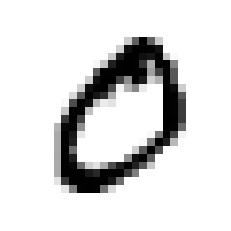

In [12]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X[1]
plot_digit(some_digit)
plt.show()

In [13]:
y[1]

'0'

You should always create a test set and set it aside before inspecting the data closely. The MNIST dataset returned by fetch_openml() is actually already split into a training set (the first 60,000 images) and a test set (the last 10,000 images)

In [14]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [15]:
print(X_train.shape, y_train.shape)

(60000, 784) (60000,)


In [16]:
print(X_test.shape, y_test.shape)

(10000, 784) (10000,)


# Training a Binary Classifier

Suppose I want to build a model to classify the number 0, "0-detector". This is a binary classifier since the corresponding outcome is either zero or not.

In [17]:
set(y_train)

{'0', '1', '2', '3', '4', '5', '6', '7', '8', '9'}

In [18]:
y_train == 0

array([False, False, False, ..., False, False, False])

In [19]:
y_train_0 = (y_train == 0)
y_train_0.sum()

0

What's wrong?

In [20]:
y_train_0 = (y_train == '0')
y_train_0.sum()

5923

In [21]:
y_test_0 = (y_test == '0')

Now let’s pick a classifier and train it. A good place to start is with a stochastic gradient descent (SGD, or stochastic GD) classifier, using Scikit-Learn’s SGDClassifier class. This classifier is capable of handling very large datasets efficiently. This is in part because SGD deals with training instances independently, one at a time, which also makes SGD well suited for online learning, as you will see later. 

In [22]:
from sklearn.linear_model import SGDClassifier
# Remember the structure of LinearRegression estimator

In [23]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_0)

SGDClassifier(random_state=42)

Let's see what attributes are available: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html


In [24]:
sgd_clf.coef_.shape

(1, 784)

In [25]:
X_train.shape

(60000, 784)

In [26]:
print(y[2])
sgd_clf.predict([X[2]])

4


array([False])

In [27]:
print(y[1])
sgd_clf.predict([X[1]])

0


array([ True])

# Performance Measures

We use score() to measure the LinearRegression performance, which is $R^2$. Now see: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier.score

In [28]:
sgd_clf.score(X_train, y_train_0)

0.99155

Let's use the cross_val_score() function to evaluate our SGDClassifier model, using k-fold cross-validation with three folds. Remember that k-fold cross-validation means splitting the training set into k folds (in this case, three), then training the model k times, holding out a different fold each time for evaluation

In [29]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_0, cv=3, scoring="accuracy")

array([0.9854, 0.9847, 0.9865])

Above 90 percent accuracy seems amazing, but see:

In [30]:
100 - y_train_0.sum() / len(y_train) * 100

90.12833333333333

If you always guess that an image is not a 0, you will be right about 90% of the time. It is generally not the preferred performance measure for classifiers, especially when you are dealing with skewed datasets. 

# Confusion Matrices

Suppose there is a binary actual target, Positive and Negative. And there is an outcome of classification, Positive and negative. Then you can come up with 4 different combinations of predicated and actual values:

    - true positive
    - false positive (actual target is negative, but the model predicts positive)
        - a.k.a type I error
    - true negative
    - false negative (actual target is positive, but the model predicts negative)
        - type II error

You could make predictions on the test set, but it’s best to keep that untouched for now (remember that you want to use the test set only at the very end of your project, once you have a classifier that you are ready to launch). Instead, you can use the cross_val_predict() function:

In [32]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_0, cv=3)

Just like the cross_val_score() function, cross_val_predict() performs k-fold cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each test fold

In [33]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_0, y_train_pred)
cm

array([[53486,   591],
       [  277,  5646]])

The first row of this matrix considers non-0 images (the negative class): 53,486 of them were correctly classified as non-0s (they are called true negatives), while the remaining 591 were wrongly classified as 0s (false positives, also called type I errors). The second row considers the images of 0s (the positive class): 277 were wrongly classified as non-0s (false negatives, also called type II errors), while the remaining 5,646 were correctly classified as 0s (true positives)

In [35]:
from IPython.display import Image
Image(url="https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781098125967/files/assets/mls3_0303.png", width=900, height=500)

In case, if you need more concise metric: use *precision* and *recall*

$$\text{precision}=\frac{TP}{TP+FP}$$
$$\text{recall}=\frac{TP}{TP+FN}$$

In [41]:
from sklearn.metrics import precision_score, recall_score
print("precision of 0 detector: {:.03f}".format(precision_score(y_train_0, y_train_pred)))
print("sensitivity of 0 detector: {:.03f}".format(recall_score(y_train_0, y_train_pred)))

precision of 0 detector: 0.905
sensitivity of 0 detector: 0.953


When it claims an image represents a 0, it is correct only 90.5% of the time. Moreover, it detects 95.3% of the 0s.

1. Is this a good classifier?
    - What's left to test
2. When do we need precision over sensitivity? Or sensitivity over precision?

In [43]:
y_train_5 = (y_train == '5')
sgd_clf.fit(X_train, y_train_5)
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
print("precision of 5 detector: {:.03f}".format(precision_score(y_train_5, y_train_pred)))
print("sensitivity of 5 detector: {:.03f}".format(recall_score(y_train_5, y_train_pred)))

precision of 5 detector: 0.837
sensitivity of 5 detector: 0.651


...in some contexts you mostly care about precision, and in other contexts you really care about recall. For example, if you trained a classifier to detect videos that are safe for kids, you would probably prefer a classifier that rejects many good videos (low recall) but keeps only safe ones (high precision), rather than a classifier that has a much higher recall but lets a few really bad videos show up in your product (in such cases, you may even want to add a human pipeline to check the classifier’s video selection). On the other hand, suppose you train a classifier to detect shoplifters in surveillance images: it is probably fine if your classifier only has 30% precision as long as it has 99% recall (sure, the security guards will get a few false alerts, but almost all shoplifters will get caught).

Unfortunately, you can’t have it both ways: increasing precision reduces recall, and vice versa. This is called the precision/recall trade-off.

# The Precision/Recall Trade-off

# The ROC Curve

# Error Analysis

# Naive Bayes

# KNN